In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [19]:
df = pd.read_csv("data/retail_transactions.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y,average_discount,holiday,week_before_holiday
0,Books,2023-04-29,841.510147,1,0,0
1,Books,2023-04-30,16875.994336,1,0,0
2,Books,2023-05-01,15940.233894,2,0,0
3,Books,2023-05-02,20267.366423,2,0,0
4,Books,2023-05-03,16548.154523,1,0,0


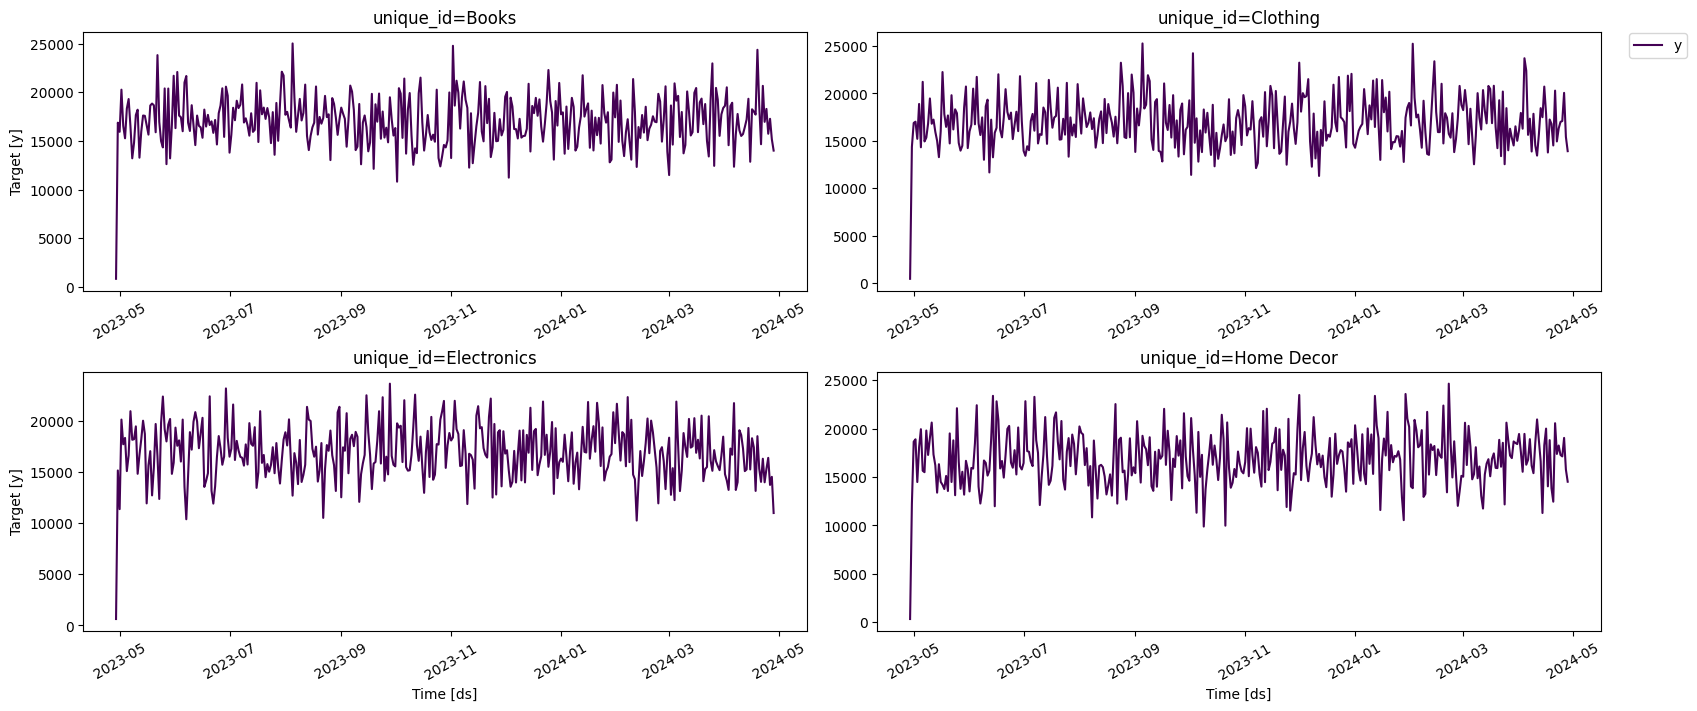

In [20]:
plot_series(df=df, palette="viridis")

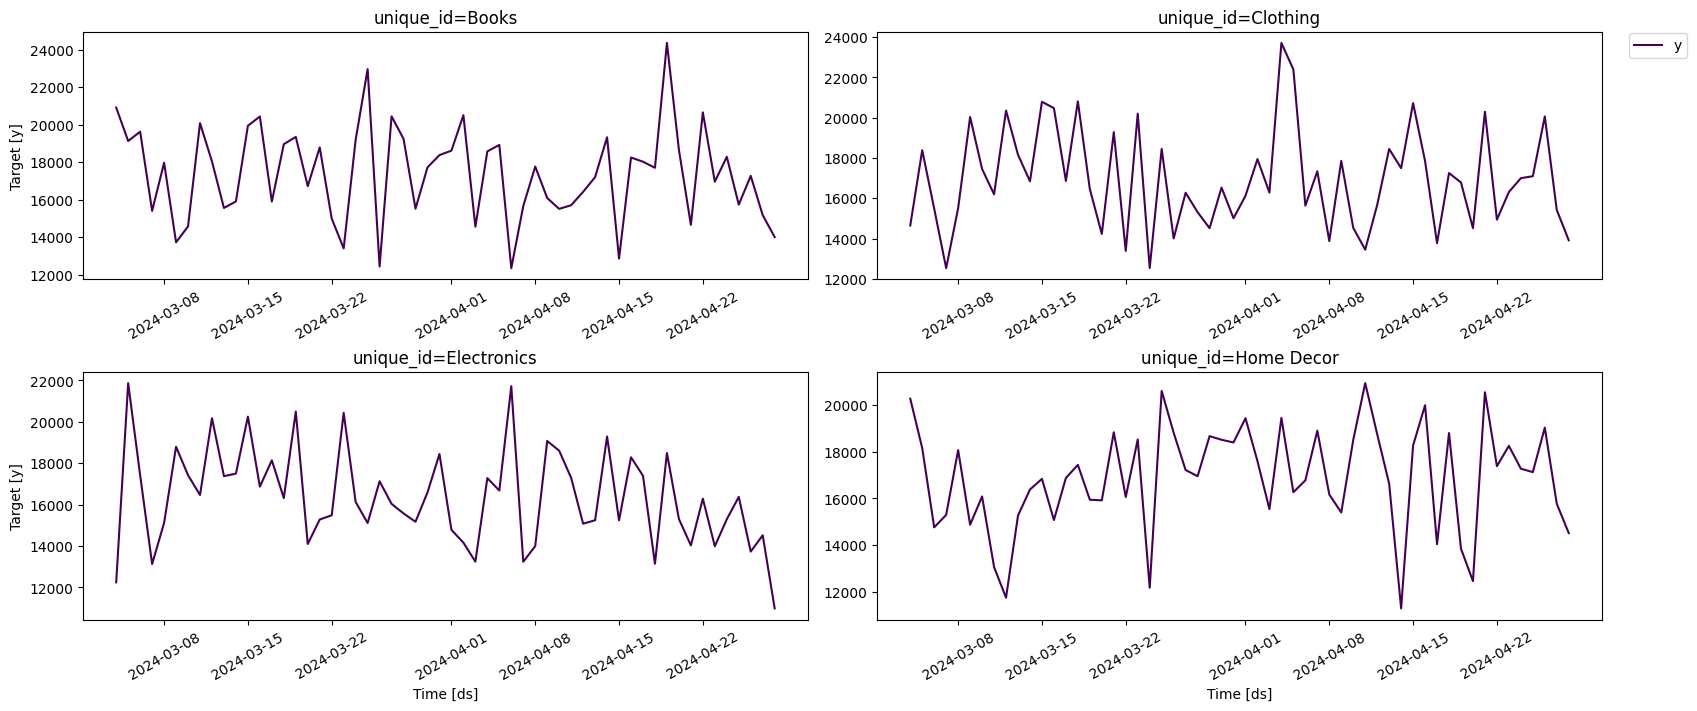

In [21]:
plot_series(df=df, max_insample_length=56, palette="viridis")

## Pretrain a model

In [22]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import MSE

In [23]:
books_df = df[df["unique_id"].isin(["Books"])]
books_df.head()

,unique_id,ds,y,average_discount,holiday,week_before_holiday
0,Books,2023-04-29,841.510147,1,0,0
1,Books,2023-04-30,16875.994336,1,0,0
2,Books,2023-05-01,15940.233894,2,0,0
3,Books,2023-05-02,20267.366423,2,0,0
4,Books,2023-05-03,16548.154523,1,0,0


In [8]:
horizon = 28

models = [
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        loss=MSE(),
        valid_loss=MSE(),
        scaler_type="robust",
        early_stop_patience_steps=3,
        max_steps=1000
    )
]

nf = NeuralForecast(models=models, freq="D")
nf.fit(df=books_df, val_size=horizon)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MSE               | 0     
1 | valid_loss   | MSE               | 0     
2 | padder_train | ConstantPad1d     | 0     
3 | scaler       | TemporalNorm      | 0     
4 | model        | PatchTST_backbone | 425 K 
---------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)


Epoch 99: 100%|██████████████████| 1/1 [00:00<00:00,  3.32it/s, v_num=1, train_loss_step=2.450, train_loss_epoch=2.500]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  3.32it/s, v_num=1, train_loss_step=2.090, train_loss_epoch=2.110, valid_loss=7.17
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  3.38it/s, v_num=1, train_loss_step=1.710, train_loss_epoch=1.740, valid_loss=8.28
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

In [9]:
nf.save(
    path="./models",
    overwrite=True,
    save_dataset=False
)

## Transfer learning

In [24]:
pretrained_model = NeuralForecast.load(path="./models")

Seed set to 1


In [25]:
others_df = df[~df["unique_id"].isin(books_df["unique_id"])]

In [38]:
test_df = others_df.sort_values(["unique_id", "ds"]).groupby("unique_id").tail(28)
input_df = others_df[~others_df.index.isin(test_df.index)]

### Zero-shot forecasting

In [29]:
zero_shot_fcsts = pretrained_model.predict(
    df=input_df
)
zero_shot_fcsts = zero_shot_fcsts.rename(columns={"PatchTST": "PatchTST_ZS"})
zero_shot_fcsts.head()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.01it/s]


,unique_id,ds,PatchTST_ZS
0,Clothing,2024-04-01,21954.923828
1,Clothing,2024-04-02,17288.763672
2,Clothing,2024-04-03,15523.222656
3,Clothing,2024-04-04,17327.554688
4,Clothing,2024-04-05,17285.910156


### Fine-tuning

In [30]:
def set_max_steps(nf, max_steps):
    trainer_kwargs = {**{"max_steps": max_steps}}
    nf.models[0].trainer_kwargs = trainer_kwargs

set_max_steps(pretrained_model, 20)

In [32]:
pretrained_model.fit(df=input_df, val_size=28)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MSE               | 0     
1 | valid_loss   | MSE               | 0     
2 | padder_train | ConstantPad1d     | 0     
3 | scaler       | TemporalNorm      | 0     
4 | model        | PatchTST_backbone | 425 K 
---------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)


Epoch 19: 100%|██████████████████| 1/1 [00:00<00:00,  3.34it/s, v_num=9, train_loss_step=2.990, train_loss_epoch=2.990]

`Trainer.fit` stopped: `max_steps=20` reached.


Epoch 19: 100%|██████████████████| 1/1 [00:00<00:00,  3.31it/s, v_num=9, train_loss_step=2.990, train_loss_epoch=2.990]


In [34]:
finetuned_fcsts = pretrained_model.predict()
finetuned_fcsts = finetuned_fcsts.rename(columns={"PatchTST": "PatchTST_FT"})
finetuned_fcsts.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


,unique_id,ds,PatchTST_FT
0,Clothing,2024-04-01,20796.982422
1,Clothing,2024-04-02,17490.878906
2,Clothing,2024-04-03,16271.296875
3,Clothing,2024-04-04,17856.988281
4,Clothing,2024-04-05,17389.816406


### Data-specfic model

In [35]:
horizon = 28

models = [
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        loss=MSE(),
        valid_loss=MSE(),
        scaler_type="robust",
        early_stop_patience_steps=3,
        max_steps=1000
    )
]

nf = NeuralForecast(models=models, freq="D")
nf.fit(df=input_df, val_size=horizon)
fcsts = nf.predict()
fcsts.head()

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MSE               | 0     
1 | valid_loss   | MSE               | 0     
2 | padder_train | ConstantPad1d     | 0     
3 | scaler       | TemporalNorm      | 0     
4 | model        | PatchTST_backbone | 425 K 
---------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.703     Total estimated model params size (MB)


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00,  3.26it/s, v_num=11, train_loss_step=2.580, train_loss_epoch=2.580]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.68it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  3.23it/s, v_num=11, train_loss_step=2.490, train_loss_epoch=2.500, valid_loss=5.8
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  3.33it/s, v_num=11, train_loss_step=2.380, train_loss_epoch=2.390, valid_loss=5.8
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.11it/s]


,unique_id,ds,PatchTST
0,Clothing,2024-04-01,17682.943359
1,Clothing,2024-04-02,17729.091797
2,Clothing,2024-04-03,18548.460938
3,Clothing,2024-04-04,18873.482422
4,Clothing,2024-04-05,17634.166016


## Evaluation

In [39]:
test_df = pd.merge(test_df, zero_shot_fcsts, 'left', ["unique_id", "ds"])
test_df = pd.merge(test_df, finetuned_fcsts, 'left', ["unique_id", "ds"])
test_df = pd.merge(test_df, fcsts, 'left', ["unique_id", "ds"])

test_df = test_df.drop(columns=["average_discount", "holiday", "week_before_holiday"])
test_df.head()

,unique_id,ds,y,PatchTST_ZS,PatchTST_FT,PatchTST
0,Clothing,2024-04-01,16124.193778,21954.923828,20796.982422,17682.943359
1,Clothing,2024-04-02,17945.546845,17288.763672,17490.878906,17729.091797
2,Clothing,2024-04-03,16282.477213,15523.222656,16271.296875,18548.460938
3,Clothing,2024-04-04,23715.686341,17327.554688,17856.988281,18873.482422
4,Clothing,2024-04-05,22398.255210,17285.910156,17389.816406,17634.166016


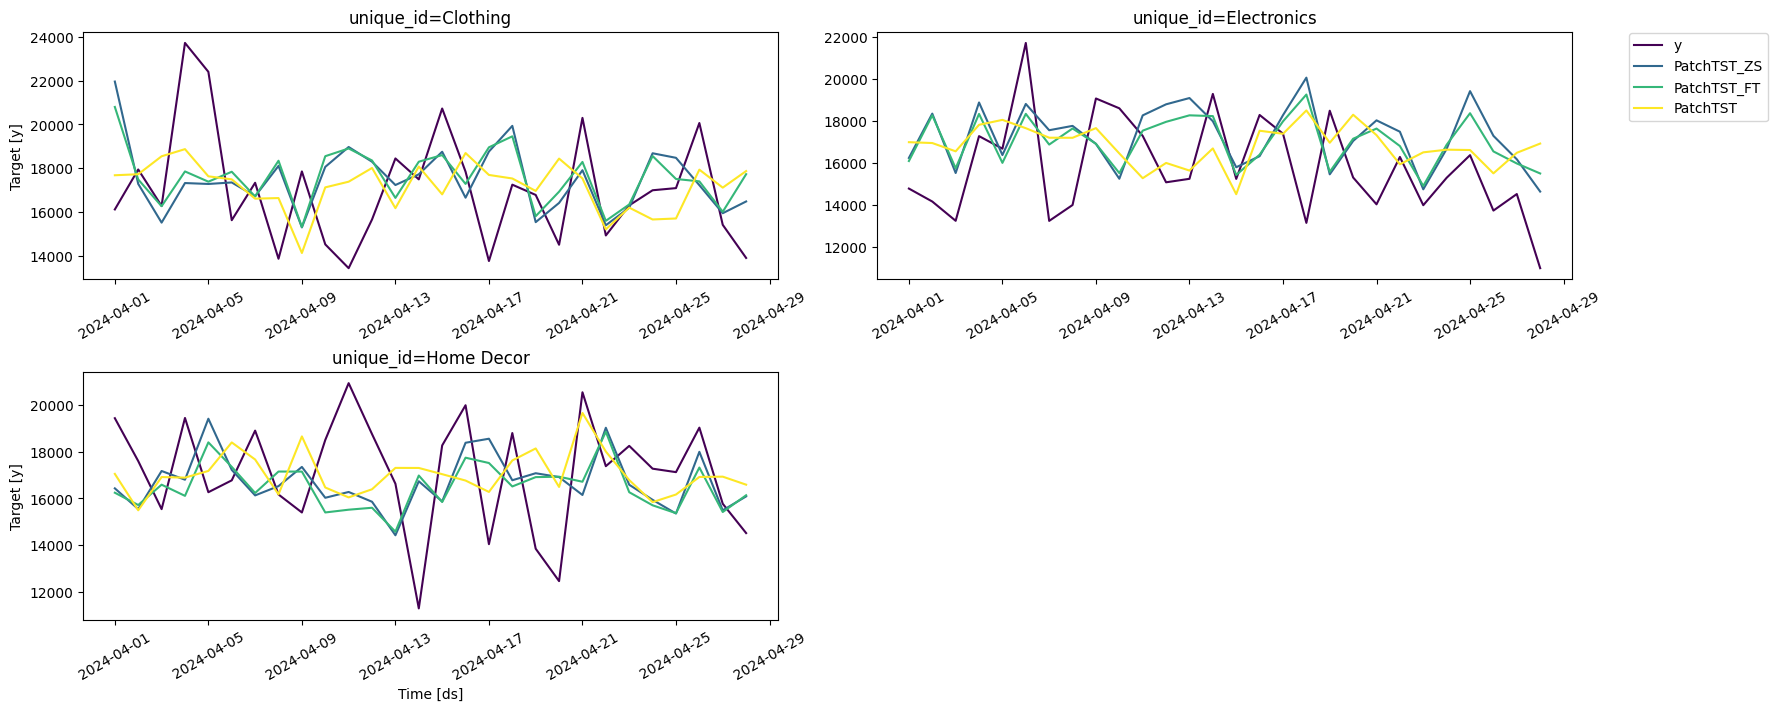

In [42]:
plot_series(df=test_df, forecasts_df=test_df.drop(columns="y"), palette="viridis")

In [43]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    agg_fn="mean"
)

evaluation

,metric,PatchTST_ZS,PatchTST_FT,PatchTST
0,mae,2444.216326,2369.435952,2136.026486
1,smape,0.072643,0.070824,0.064353
